# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=350  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=512, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=64, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=64, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

In [18]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


     


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        

        #w=w[0]-torch.mean(w[0])
    
        a=torch.randn(1).cuda()*0.1
        
        # 策略1
#         b=int(a*10)
#         if b>0:
#             w=w[b]
#         else:
#             w=w[0]
        
        #
        w=w[0]
        #w=torch.randn(w[0].shape).cuda()*1
        
        
        if a>0.376:
            print("Global mean vector:",w.shape)
            print(w)
            print("scores:",self.conv2.weight.shape)
            print(self.conv2.weight)
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), (1024,1)]
    #cfg = [48, (96,2), 96, (192,2), 192, (384,2), 384, 384, 384, 384, 384, (768,2), (1024,1)]
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512,1024,1024]
    cfg = [48, (96,2), 96, 192, 192, (384,2), 384, 384, 384, 384, 384,768,768]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(768, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        #print("X",out.shape)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [19]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [20]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1=open("Cifar10_INFO.txt","a+")
            f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [21]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [22]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    f1.close()

In [23]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [ ]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.318358, Accuracy: 10.35
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.293466, Accuracy: 12.11
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.121346, Accuracy: 22.66
Train Epoch: 0 [7680/50000 (17%)]	Loss: 1.877073, Accuracy: 26.76
Train Epoch: 0 [10240/50000 (23%)]	Loss: 1.837668, Accuracy: 27.15
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.834268, Accuracy: 23.44
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.825325, Accuracy: 30.08
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.713087, Accuracy: 34.57
Train Epoch: 0 [20480/50000 (45%)]	Loss: 1.696611, Accuracy: 34.38
Train Epoch: 0 [23040/50000 (51%)]	Loss: 1.599995, Accuracy: 40.82
Train Epoch: 0 [25600/50000 (57%)]	Loss: 1.654794, Accuracy: 38.28
Train Epoch: 0 [28160/50000 (62%)]	Loss: 1.612942, Accuracy: 35.94
Train Epoch: 0 [30720/50000 (68%)]	Loss: 1.576404, Accuracy: 40.04
Train Epoch: 0 [33280/50000 (74%)]	Loss: 1.551463, Accuracy: 43.36
Train Epoch: 0 [35840/50000 (80%)]	Loss: 1.501849, Accuracy: 44.73
Trai


Validation set: Average loss: 1.5467, Accuracy: 2578/5000 (51.00%)

the time of this epoch:[27.851522207260132 s]
Train Epoch: 6 [0/50000 (0%)]	Loss: 0.607831, Accuracy: 78.91
Train Epoch: 6 [2560/50000 (6%)]	Loss: 0.611934, Accuracy: 78.12
Train Epoch: 6 [5120/50000 (11%)]	Loss: 0.543641, Accuracy: 80.47
Train Epoch: 6 [7680/50000 (17%)]	Loss: 0.601585, Accuracy: 77.15
Train Epoch: 6 [10240/50000 (23%)]	Loss: 0.648702, Accuracy: 76.76
Train Epoch: 6 [12800/50000 (28%)]	Loss: 0.689830, Accuracy: 76.76
Train Epoch: 6 [15360/50000 (34%)]	Loss: 0.595397, Accuracy: 80.86
Train Epoch: 6 [17920/50000 (40%)]	Loss: 0.577023, Accuracy: 78.71
Train Epoch: 6 [20480/50000 (45%)]	Loss: 0.600229, Accuracy: 79.88
Train Epoch: 6 [23040/50000 (51%)]	Loss: 0.612499, Accuracy: 78.52
Train Epoch: 6 [25600/50000 (57%)]	Loss: 0.638144, Accuracy: 78.32
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.674128, Accuracy: 76.95
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.556353, Accuracy: 78.32
Train Epoch: 6 [33280/5

Train Epoch: 12 [5120/50000 (11%)]	Loss: 0.471365, Accuracy: 82.81
Train Epoch: 12 [7680/50000 (17%)]	Loss: 0.383516, Accuracy: 86.13
Train Epoch: 12 [10240/50000 (23%)]	Loss: 0.384511, Accuracy: 87.50
Train Epoch: 12 [12800/50000 (28%)]	Loss: 0.359955, Accuracy: 89.26
Train Epoch: 12 [15360/50000 (34%)]	Loss: 0.413839, Accuracy: 84.38
Train Epoch: 12 [17920/50000 (40%)]	Loss: 0.438713, Accuracy: 83.79
Train Epoch: 12 [20480/50000 (45%)]	Loss: 0.462388, Accuracy: 85.16
Train Epoch: 12 [23040/50000 (51%)]	Loss: 0.417108, Accuracy: 84.77
Train Epoch: 12 [25600/50000 (57%)]	Loss: 0.443625, Accuracy: 85.74
Train Epoch: 12 [28160/50000 (62%)]	Loss: 0.521556, Accuracy: 84.96
Train Epoch: 12 [30720/50000 (68%)]	Loss: 0.419936, Accuracy: 84.77
Train Epoch: 12 [33280/50000 (74%)]	Loss: 0.481166, Accuracy: 85.74
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.457493, Accuracy: 83.20
Train Epoch: 12 [38400/50000 (85%)]	Loss: 0.399552, Accuracy: 86.13
Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.421756

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.344928, Accuracy: 88.28
Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.368582, Accuracy: 87.11
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.394952, Accuracy: 85.55
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.443283, Accuracy: 84.96
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.352800, Accuracy: 86.13
Train Epoch: 13 [12800/50000 (28%)]	Loss: 0.381324, Accuracy: 86.72
Train Epoch: 13 [15360/50000 (34%)]	Loss: 0.386221, Accuracy: 84.96
Train Epoch: 13 [17920/50000 (40%)]	Loss: 0.450588, Accuracy: 83.40
Train Epoch: 13 [20480/50000 (45%)]	Loss: 0.380746, Accuracy: 86.33
Train Epoch: 13 [23040/50000 (51%)]	Loss: 0.380998, Accuracy: 86.13
Train Epoch: 13 [25600/50000 (57%)]	Loss: 0.346576, Accuracy: 87.50
Train Epoch: 13 [28160/50000 (62%)]	Loss: 0.491023, Accuracy: 83.79
Train Epoch: 13 [30720/50000 (68%)]	Loss: 0.434181, Accuracy: 85.55
Train Epoch: 13 [33280/50000 (74%)]	Loss: 0.483188, Accuracy: 82.03
Train Epoch: 13 [35840/50000 (80%)]	Loss: 0.469253, Accur

Train Epoch: 16 [12800/50000 (28%)]	Loss: 0.319770, Accuracy: 88.87
Train Epoch: 16 [15360/50000 (34%)]	Loss: 0.325034, Accuracy: 89.65
Train Epoch: 16 [17920/50000 (40%)]	Loss: 0.367581, Accuracy: 87.11
Train Epoch: 16 [20480/50000 (45%)]	Loss: 0.366489, Accuracy: 86.52
Train Epoch: 16 [23040/50000 (51%)]	Loss: 0.352440, Accuracy: 87.89
Train Epoch: 16 [25600/50000 (57%)]	Loss: 0.429302, Accuracy: 85.94
Train Epoch: 16 [28160/50000 (62%)]	Loss: 0.379301, Accuracy: 88.09
Train Epoch: 16 [30720/50000 (68%)]	Loss: 0.354359, Accuracy: 87.50
Train Epoch: 16 [33280/50000 (74%)]	Loss: 0.369667, Accuracy: 86.13
Train Epoch: 16 [35840/50000 (80%)]	Loss: 0.326849, Accuracy: 89.65
Train Epoch: 16 [38400/50000 (85%)]	Loss: 0.385119, Accuracy: 87.30
Train Epoch: 16 [40960/50000 (91%)]	Loss: 0.386124, Accuracy: 85.74
Train Epoch: 16 [43520/50000 (97%)]	Loss: 0.362613, Accuracy: 86.91
Global mean vector: torch.Size([384, 1, 1])
tensor([[[ 0.1853]],

        [[ 0.1916]],

        [[ 0.2586]],

      


Validation set: Average loss: 0.5632, Accuracy: 4097/5000 (81.00%)

the time of this epoch:[27.769044399261475 s]

Test set: Average loss: 0.5926, Accuracy: 8078/10000 (80.78%)

Train Epoch: 17 [0/50000 (0%)]	Loss: 0.322869, Accuracy: 88.09
Train Epoch: 17 [2560/50000 (6%)]	Loss: 0.305990, Accuracy: 90.62
Train Epoch: 17 [5120/50000 (11%)]	Loss: 0.318548, Accuracy: 88.28
Train Epoch: 17 [7680/50000 (17%)]	Loss: 0.310110, Accuracy: 89.26
Train Epoch: 17 [10240/50000 (23%)]	Loss: 0.295109, Accuracy: 89.45
Train Epoch: 17 [12800/50000 (28%)]	Loss: 0.339805, Accuracy: 87.30
Train Epoch: 17 [15360/50000 (34%)]	Loss: 0.295772, Accuracy: 90.62
Train Epoch: 17 [17920/50000 (40%)]	Loss: 0.317811, Accuracy: 90.04
Train Epoch: 17 [20480/50000 (45%)]	Loss: 0.304392, Accuracy: 90.62
Train Epoch: 17 [23040/50000 (51%)]	Loss: 0.370692, Accuracy: 87.70
Train Epoch: 17 [25600/50000 (57%)]	Loss: 0.411972, Accuracy: 85.16
Train Epoch: 17 [28160/50000 (62%)]	Loss: 0.346109, Accuracy: 89.84
Train Epoch: 1

Global mean vector: torch.Size([384, 1, 1])
tensor([[[ 0.0419]],

        [[ 0.0069]],

        [[ 0.0884]],

        [[ 0.1327]],

        [[ 0.0277]],

        [[ 0.0238]],

        [[ 0.0833]],

        [[ 0.2103]],

        [[ 0.4814]],

        [[ 0.0022]],

        [[ 0.0909]],

        [[ 0.0000]],

        [[ 0.0038]],

        [[ 0.4860]],

        [[ 0.0000]],

        [[ 0.0023]],

        [[ 0.0000]],

        [[ 0.0631]],

        [[ 0.1344]],

        [[ 0.0358]],

        [[ 0.0485]],

        [[ 0.1680]],

        [[ 0.0488]],

        [[ 0.0627]],

        [[ 0.1917]],

        [[ 0.0046]],

        [[ 0.2010]],

        [[ 0.0709]],

        [[ 0.0009]],

        [[ 0.0022]],

        [[ 0.1824]],

        [[ 0.0327]],

        [[ 0.0615]],

        [[ 0.1546]],

        [[ 0.0228]],

        [[ 0.1415]],

        [[ 0.0334]],

        [[ 0.0027]],

        [[ 0.0254]],

        [[ 0.0156]],

        [[ 0.0646]],

        [[ 0.0732]],

        [[ 0.0034]],

        [[


Test set: Average loss: 0.6667, Accuracy: 7961/10000 (79.61%)

Train Epoch: 23 [0/50000 (0%)]	Loss: 0.325744, Accuracy: 88.67
Train Epoch: 23 [2560/50000 (6%)]	Loss: 0.275290, Accuracy: 90.04
Train Epoch: 23 [5120/50000 (11%)]	Loss: 0.269054, Accuracy: 91.02
Train Epoch: 23 [7680/50000 (17%)]	Loss: 0.314596, Accuracy: 88.48
Train Epoch: 23 [10240/50000 (23%)]	Loss: 0.262339, Accuracy: 90.62
Train Epoch: 23 [12800/50000 (28%)]	Loss: 0.239767, Accuracy: 91.60
Train Epoch: 23 [15360/50000 (34%)]	Loss: 0.305200, Accuracy: 91.02
Train Epoch: 23 [17920/50000 (40%)]	Loss: 0.318095, Accuracy: 88.87
Train Epoch: 23 [20480/50000 (45%)]	Loss: 0.324071, Accuracy: 87.11
Train Epoch: 23 [23040/50000 (51%)]	Loss: 0.350333, Accuracy: 86.91
Train Epoch: 23 [25600/50000 (57%)]	Loss: 0.290822, Accuracy: 90.23
Train Epoch: 23 [28160/50000 (62%)]	Loss: 0.293725, Accuracy: 88.48
Train Epoch: 23 [30720/50000 (68%)]	Loss: 0.317720, Accuracy: 88.87
Train Epoch: 23 [33280/50000 (74%)]	Loss: 0.280764, Accuracy:


Validation set: Average loss: 0.6303, Accuracy: 4029/5000 (80.00%)

the time of this epoch:[27.85650897026062 s]

Test set: Average loss: 0.6400, Accuracy: 8031/10000 (80.31%)

Train Epoch: 25 [0/50000 (0%)]	Loss: 0.256566, Accuracy: 92.19
Train Epoch: 25 [2560/50000 (6%)]	Loss: 0.305586, Accuracy: 89.26
Train Epoch: 25 [5120/50000 (11%)]	Loss: 0.274720, Accuracy: 89.06
Train Epoch: 25 [7680/50000 (17%)]	Loss: 0.307671, Accuracy: 89.06
Train Epoch: 25 [10240/50000 (23%)]	Loss: 0.261373, Accuracy: 89.84
Train Epoch: 25 [12800/50000 (28%)]	Loss: 0.284234, Accuracy: 90.23
Train Epoch: 25 [15360/50000 (34%)]	Loss: 0.283389, Accuracy: 90.82
Train Epoch: 25 [17920/50000 (40%)]	Loss: 0.315436, Accuracy: 89.26
Train Epoch: 25 [20480/50000 (45%)]	Loss: 0.273711, Accuracy: 89.45
Train Epoch: 25 [23040/50000 (51%)]	Loss: 0.325928, Accuracy: 88.87
Train Epoch: 25 [25600/50000 (57%)]	Loss: 0.286080, Accuracy: 90.82
Train Epoch: 25 [28160/50000 (62%)]	Loss: 0.314159, Accuracy: 89.45
Train Epoch: 25


Test set: Average loss: 0.6846, Accuracy: 7928/10000 (79.28%)

Train Epoch: 31 [0/50000 (0%)]	Loss: 0.271420, Accuracy: 91.21
Train Epoch: 31 [2560/50000 (6%)]	Loss: 0.253807, Accuracy: 90.23
Train Epoch: 31 [5120/50000 (11%)]	Loss: 0.269456, Accuracy: 90.82
Train Epoch: 31 [7680/50000 (17%)]	Loss: 0.324586, Accuracy: 90.04
Train Epoch: 31 [10240/50000 (23%)]	Loss: 0.235483, Accuracy: 91.41
Train Epoch: 31 [12800/50000 (28%)]	Loss: 0.302448, Accuracy: 90.04
Train Epoch: 31 [15360/50000 (34%)]	Loss: 0.296101, Accuracy: 90.23
Train Epoch: 31 [17920/50000 (40%)]	Loss: 0.213105, Accuracy: 91.60
Train Epoch: 31 [20480/50000 (45%)]	Loss: 0.364188, Accuracy: 87.89
Train Epoch: 31 [23040/50000 (51%)]	Loss: 0.267646, Accuracy: 90.82
Train Epoch: 31 [25600/50000 (57%)]	Loss: 0.273276, Accuracy: 90.04
Train Epoch: 31 [28160/50000 (62%)]	Loss: 0.285858, Accuracy: 89.06
Train Epoch: 31 [30720/50000 (68%)]	Loss: 0.328175, Accuracy: 89.45
Train Epoch: 31 [33280/50000 (74%)]	Loss: 0.266952, Accuracy:

Train Epoch: 33 [15360/50000 (34%)]	Loss: 0.323757, Accuracy: 87.70
Train Epoch: 33 [17920/50000 (40%)]	Loss: 0.212685, Accuracy: 91.99
Train Epoch: 33 [20480/50000 (45%)]	Loss: 0.287208, Accuracy: 91.41
Train Epoch: 33 [23040/50000 (51%)]	Loss: 0.233178, Accuracy: 93.95
Train Epoch: 33 [25600/50000 (57%)]	Loss: 0.238895, Accuracy: 91.41
Train Epoch: 33 [28160/50000 (62%)]	Loss: 0.281003, Accuracy: 90.82
Train Epoch: 33 [30720/50000 (68%)]	Loss: 0.203653, Accuracy: 92.38
Train Epoch: 33 [33280/50000 (74%)]	Loss: 0.264025, Accuracy: 90.23
Train Epoch: 33 [35840/50000 (80%)]	Loss: 0.214396, Accuracy: 92.77
Train Epoch: 33 [38400/50000 (85%)]	Loss: 0.308400, Accuracy: 88.87
Train Epoch: 33 [40960/50000 (91%)]	Loss: 0.278324, Accuracy: 90.04
Train Epoch: 33 [43520/50000 (97%)]	Loss: 0.330980, Accuracy: 88.67

Validation set: Average loss: 0.5073, Accuracy: 4157/5000 (83.00%)

the time of this epoch:[30.888184070587158 s]
Train Epoch: 34 [0/50000 (0%)]	Loss: 0.254893, Accuracy: 90.43
Train 

Train Epoch: 39 [17920/50000 (40%)]	Loss: 0.272349, Accuracy: 91.02
Train Epoch: 39 [20480/50000 (45%)]	Loss: 0.250712, Accuracy: 90.62
Train Epoch: 39 [23040/50000 (51%)]	Loss: 0.279736, Accuracy: 90.62
Train Epoch: 39 [25600/50000 (57%)]	Loss: 0.245212, Accuracy: 90.62
Train Epoch: 39 [28160/50000 (62%)]	Loss: 0.334846, Accuracy: 87.89
Train Epoch: 39 [30720/50000 (68%)]	Loss: 0.326181, Accuracy: 88.09
Train Epoch: 39 [33280/50000 (74%)]	Loss: 0.272442, Accuracy: 90.23
Train Epoch: 39 [35840/50000 (80%)]	Loss: 0.213756, Accuracy: 93.16
Train Epoch: 39 [38400/50000 (85%)]	Loss: 0.288702, Accuracy: 89.84
Train Epoch: 39 [40960/50000 (91%)]	Loss: 0.256697, Accuracy: 90.43
Train Epoch: 39 [43520/50000 (97%)]	Loss: 0.324070, Accuracy: 89.45

Validation set: Average loss: 0.4892, Accuracy: 4188/5000 (83.00%)

the time of this epoch:[31.310367345809937 s]
Train Epoch: 40 [0/50000 (0%)]	Loss: 0.232119, Accuracy: 92.97
Train Epoch: 40 [2560/50000 (6%)]	Loss: 0.284400, Accuracy: 90.62
Train Ep

Train Epoch: 43 [40960/50000 (91%)]	Loss: 0.216462, Accuracy: 92.97
Train Epoch: 43 [43520/50000 (97%)]	Loss: 0.255243, Accuracy: 91.99

Validation set: Average loss: 0.4865, Accuracy: 4262/5000 (85.00%)

the time of this epoch:[31.300158739089966 s]
Train Epoch: 44 [0/50000 (0%)]	Loss: 0.211445, Accuracy: 91.80
Train Epoch: 44 [2560/50000 (6%)]	Loss: 0.213315, Accuracy: 92.38
Train Epoch: 44 [5120/50000 (11%)]	Loss: 0.292746, Accuracy: 89.65
Train Epoch: 44 [7680/50000 (17%)]	Loss: 0.235397, Accuracy: 91.60
Train Epoch: 44 [10240/50000 (23%)]	Loss: 0.235040, Accuracy: 92.77
Train Epoch: 44 [12800/50000 (28%)]	Loss: 0.246479, Accuracy: 92.38
Train Epoch: 44 [15360/50000 (34%)]	Loss: 0.241539, Accuracy: 91.60
Train Epoch: 44 [17920/50000 (40%)]	Loss: 0.204803, Accuracy: 92.77
Train Epoch: 44 [20480/50000 (45%)]	Loss: 0.254101, Accuracy: 91.21
Train Epoch: 44 [23040/50000 (51%)]	Loss: 0.183786, Accuracy: 92.58
Train Epoch: 44 [25600/50000 (57%)]	Loss: 0.232454, Accuracy: 91.99
Train Epoc

Train Epoch: 47 [20480/50000 (45%)]	Loss: 0.226064, Accuracy: 91.41
Train Epoch: 47 [23040/50000 (51%)]	Loss: 0.190990, Accuracy: 94.53
Train Epoch: 47 [25600/50000 (57%)]	Loss: 0.265271, Accuracy: 90.62
Train Epoch: 47 [28160/50000 (62%)]	Loss: 0.272505, Accuracy: 90.62
Train Epoch: 47 [30720/50000 (68%)]	Loss: 0.314038, Accuracy: 90.43
Train Epoch: 47 [33280/50000 (74%)]	Loss: 0.316967, Accuracy: 88.87
Train Epoch: 47 [35840/50000 (80%)]	Loss: 0.312151, Accuracy: 90.43
Train Epoch: 47 [38400/50000 (85%)]	Loss: 0.234433, Accuracy: 91.99
Train Epoch: 47 [40960/50000 (91%)]	Loss: 0.245035, Accuracy: 92.38
Train Epoch: 47 [43520/50000 (97%)]	Loss: 0.237670, Accuracy: 91.99

Validation set: Average loss: 0.5328, Accuracy: 4172/5000 (83.00%)

the time of this epoch:[31.19109606742859 s]
Train Epoch: 48 [0/50000 (0%)]	Loss: 0.215256, Accuracy: 92.19
Train Epoch: 48 [2560/50000 (6%)]	Loss: 0.184377, Accuracy: 93.16
Train Epoch: 48 [5120/50000 (11%)]	Loss: 0.215668, Accuracy: 91.99
Train Epoc

Train Epoch: 50 [2560/50000 (6%)]	Loss: 0.219789, Accuracy: 92.19
Train Epoch: 50 [5120/50000 (11%)]	Loss: 0.246774, Accuracy: 90.82
Train Epoch: 50 [7680/50000 (17%)]	Loss: 0.240437, Accuracy: 92.38
Global mean vector: torch.Size([192, 1, 1])
tensor([[[ 0.0401]],

        [[ 0.0479]],

        [[ 0.0142]],

        [[ 0.0322]],

        [[ 0.0531]],

        [[ 0.0577]],

        [[ 0.0165]],

        [[ 0.0054]],

        [[ 0.0327]],

        [[ 0.0000]],

        [[ 0.0743]],

        [[ 0.0135]],

        [[ 0.0474]],

        [[ 0.0799]],

        [[ 0.0277]],

        [[ 0.0362]],

        [[ 0.0931]],

        [[ 0.0248]],

        [[ 0.0444]],

        [[ 0.0370]],

        [[ 0.0513]],

        [[ 0.0756]],

        [[ 0.0000]],

        [[ 0.1568]],

        [[ 0.0771]],

        [[ 0.0265]],

        [[ 0.0717]],

        [[ 0.0753]],

        [[ 0.0097]],

        [[ 0.1629]],

        [[ 0.0392]],

        [[ 0.0461]],

        [[ 0.0047]],

        [[ 0.0824]],

        

Train Epoch: 52 [5120/50000 (11%)]	Loss: 0.100803, Accuracy: 96.68
Train Epoch: 52 [7680/50000 (17%)]	Loss: 0.086192, Accuracy: 96.88
Train Epoch: 52 [10240/50000 (23%)]	Loss: 0.109615, Accuracy: 96.09
Train Epoch: 52 [12800/50000 (28%)]	Loss: 0.126148, Accuracy: 96.68
Train Epoch: 52 [15360/50000 (34%)]	Loss: 0.109431, Accuracy: 96.09
Train Epoch: 52 [17920/50000 (40%)]	Loss: 0.078710, Accuracy: 97.85
Train Epoch: 52 [20480/50000 (45%)]	Loss: 0.100294, Accuracy: 96.88
Train Epoch: 52 [23040/50000 (51%)]	Loss: 0.112250, Accuracy: 95.90
Train Epoch: 52 [25600/50000 (57%)]	Loss: 0.069853, Accuracy: 98.44
Train Epoch: 52 [28160/50000 (62%)]	Loss: 0.086613, Accuracy: 96.29
Train Epoch: 52 [30720/50000 (68%)]	Loss: 0.095516, Accuracy: 96.68
Train Epoch: 52 [33280/50000 (74%)]	Loss: 0.101764, Accuracy: 96.48
Train Epoch: 52 [35840/50000 (80%)]	Loss: 0.078426, Accuracy: 97.66
Train Epoch: 52 [38400/50000 (85%)]	Loss: 0.079188, Accuracy: 97.46
Train Epoch: 52 [40960/50000 (91%)]	Loss: 0.069076


Test set: Average loss: 0.2874, Accuracy: 9131/10000 (91.31%)

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.052221, Accuracy: 98.44
Train Epoch: 55 [2560/50000 (6%)]	Loss: 0.059941, Accuracy: 98.05
Train Epoch: 55 [5120/50000 (11%)]	Loss: 0.064662, Accuracy: 97.85
Train Epoch: 55 [7680/50000 (17%)]	Loss: 0.062043, Accuracy: 97.66
Train Epoch: 55 [10240/50000 (23%)]	Loss: 0.045287, Accuracy: 98.24
Train Epoch: 55 [12800/50000 (28%)]	Loss: 0.039947, Accuracy: 98.83
Train Epoch: 55 [15360/50000 (34%)]	Loss: 0.082803, Accuracy: 98.05
Train Epoch: 55 [17920/50000 (40%)]	Loss: 0.063013, Accuracy: 98.44
Train Epoch: 55 [20480/50000 (45%)]	Loss: 0.046318, Accuracy: 98.83
Train Epoch: 55 [23040/50000 (51%)]	Loss: 0.071467, Accuracy: 97.85
Train Epoch: 55 [25600/50000 (57%)]	Loss: 0.051346, Accuracy: 98.44
Train Epoch: 55 [28160/50000 (62%)]	Loss: 0.066031, Accuracy: 97.85
Train Epoch: 55 [30720/50000 (68%)]	Loss: 0.102675, Accuracy: 97.27
Train Epoch: 55 [33280/50000 (74%)]	Loss: 0.077928, Accuracy:

Train Epoch: 57 [0/50000 (0%)]	Loss: 0.056902, Accuracy: 98.05
Train Epoch: 57 [2560/50000 (6%)]	Loss: 0.067410, Accuracy: 98.05
Train Epoch: 57 [5120/50000 (11%)]	Loss: 0.049602, Accuracy: 98.63
Train Epoch: 57 [7680/50000 (17%)]	Loss: 0.038587, Accuracy: 98.83
Train Epoch: 57 [10240/50000 (23%)]	Loss: 0.046425, Accuracy: 98.44
Train Epoch: 57 [12800/50000 (28%)]	Loss: 0.040966, Accuracy: 98.63
Train Epoch: 57 [15360/50000 (34%)]	Loss: 0.057380, Accuracy: 97.85
Train Epoch: 57 [17920/50000 (40%)]	Loss: 0.031324, Accuracy: 98.83
Train Epoch: 57 [20480/50000 (45%)]	Loss: 0.064172, Accuracy: 98.05
Train Epoch: 57 [23040/50000 (51%)]	Loss: 0.032562, Accuracy: 99.22
Train Epoch: 57 [25600/50000 (57%)]	Loss: 0.071470, Accuracy: 98.05
Train Epoch: 57 [28160/50000 (62%)]	Loss: 0.052207, Accuracy: 98.44
Train Epoch: 57 [30720/50000 (68%)]	Loss: 0.059700, Accuracy: 97.66
Train Epoch: 57 [33280/50000 (74%)]	Loss: 0.053705, Accuracy: 97.85
Train Epoch: 57 [35840/50000 (80%)]	Loss: 0.073012, Accur

Train Epoch: 60 [30720/50000 (68%)]	Loss: 0.045123, Accuracy: 98.44
Train Epoch: 60 [33280/50000 (74%)]	Loss: 0.039214, Accuracy: 98.63
Train Epoch: 60 [35840/50000 (80%)]	Loss: 0.041351, Accuracy: 99.02
Train Epoch: 60 [38400/50000 (85%)]	Loss: 0.042890, Accuracy: 98.83
Train Epoch: 60 [40960/50000 (91%)]	Loss: 0.046595, Accuracy: 97.66
Train Epoch: 60 [43520/50000 (97%)]	Loss: 0.038526, Accuracy: 98.83

Validation set: Average loss: 0.3045, Accuracy: 4577/5000 (91.00%)

the time of this epoch:[27.78505563735962 s]

Test set: Average loss: 0.3173, Accuracy: 9120/10000 (91.20%)

Train Epoch: 61 [0/50000 (0%)]	Loss: 0.033372, Accuracy: 99.02
Train Epoch: 61 [2560/50000 (6%)]	Loss: 0.035805, Accuracy: 99.02
Train Epoch: 61 [5120/50000 (11%)]	Loss: 0.049281, Accuracy: 98.83
Train Epoch: 61 [7680/50000 (17%)]	Loss: 0.036927, Accuracy: 99.02
Train Epoch: 61 [10240/50000 (23%)]	Loss: 0.030213, Accuracy: 98.44
Train Epoch: 61 [12800/50000 (28%)]	Loss: 0.036054, Accuracy: 99.02
Train Epoch: 61


Validation set: Average loss: 0.3287, Accuracy: 4584/5000 (91.00%)

the time of this epoch:[31.26366376876831 s]
Train Epoch: 66 [0/50000 (0%)]	Loss: 0.014912, Accuracy: 99.80
Train Epoch: 66 [2560/50000 (6%)]	Loss: 0.022246, Accuracy: 99.22
Train Epoch: 66 [5120/50000 (11%)]	Loss: 0.021415, Accuracy: 99.41
Train Epoch: 66 [7680/50000 (17%)]	Loss: 0.016041, Accuracy: 99.41
Train Epoch: 66 [10240/50000 (23%)]	Loss: 0.019689, Accuracy: 99.41
Train Epoch: 66 [12800/50000 (28%)]	Loss: 0.020670, Accuracy: 99.61
Train Epoch: 66 [15360/50000 (34%)]	Loss: 0.015665, Accuracy: 99.41
Train Epoch: 66 [17920/50000 (40%)]	Loss: 0.015521, Accuracy: 99.61
Train Epoch: 66 [20480/50000 (45%)]	Loss: 0.027170, Accuracy: 99.02
Train Epoch: 66 [23040/50000 (51%)]	Loss: 0.021450, Accuracy: 99.61
Train Epoch: 66 [25600/50000 (57%)]	Loss: 0.022481, Accuracy: 99.22
Train Epoch: 66 [28160/50000 (62%)]	Loss: 0.028307, Accuracy: 99.22
Train Epoch: 66 [30720/50000 (68%)]	Loss: 0.012576, Accuracy: 99.80
Train Epoch

Train Epoch: 68 [0/50000 (0%)]	Loss: 0.018530, Accuracy: 99.61
Train Epoch: 68 [2560/50000 (6%)]	Loss: 0.015182, Accuracy: 99.61
Train Epoch: 68 [5120/50000 (11%)]	Loss: 0.027758, Accuracy: 98.83
Train Epoch: 68 [7680/50000 (17%)]	Loss: 0.023012, Accuracy: 99.02
Train Epoch: 68 [10240/50000 (23%)]	Loss: 0.017606, Accuracy: 99.61
Train Epoch: 68 [12800/50000 (28%)]	Loss: 0.038135, Accuracy: 98.63
Train Epoch: 68 [15360/50000 (34%)]	Loss: 0.014174, Accuracy: 99.80
Train Epoch: 68 [17920/50000 (40%)]	Loss: 0.014805, Accuracy: 99.61
Train Epoch: 68 [20480/50000 (45%)]	Loss: 0.016211, Accuracy: 99.61
Train Epoch: 68 [23040/50000 (51%)]	Loss: 0.033734, Accuracy: 98.83
Train Epoch: 68 [25600/50000 (57%)]	Loss: 0.015113, Accuracy: 100.00
Train Epoch: 68 [28160/50000 (62%)]	Loss: 0.016750, Accuracy: 99.61
Train Epoch: 68 [30720/50000 (68%)]	Loss: 0.018915, Accuracy: 99.61
Train Epoch: 68 [33280/50000 (74%)]	Loss: 0.021578, Accuracy: 99.41
Train Epoch: 68 [35840/50000 (80%)]	Loss: 0.017827, Accu

Train Epoch: 70 [43520/50000 (97%)]	Loss: 0.019225, Accuracy: 99.41

Validation set: Average loss: 0.3366, Accuracy: 4592/5000 (91.00%)

the time of this epoch:[27.66303825378418 s]

Test set: Average loss: 0.3491, Accuracy: 9147/10000 (91.47%)

Train Epoch: 71 [0/50000 (0%)]	Loss: 0.019485, Accuracy: 99.41
Train Epoch: 71 [2560/50000 (6%)]	Loss: 0.016299, Accuracy: 99.61
Train Epoch: 71 [5120/50000 (11%)]	Loss: 0.023712, Accuracy: 99.61
Train Epoch: 71 [7680/50000 (17%)]	Loss: 0.013905, Accuracy: 99.80
Train Epoch: 71 [10240/50000 (23%)]	Loss: 0.025817, Accuracy: 99.41
Train Epoch: 71 [12800/50000 (28%)]	Loss: 0.032692, Accuracy: 99.22
Train Epoch: 71 [15360/50000 (34%)]	Loss: 0.018952, Accuracy: 99.22
Train Epoch: 71 [17920/50000 (40%)]	Loss: 0.014243, Accuracy: 99.61
Train Epoch: 71 [20480/50000 (45%)]	Loss: 0.025821, Accuracy: 99.22
Train Epoch: 71 [23040/50000 (51%)]	Loss: 0.022011, Accuracy: 99.80
Train Epoch: 71 [25600/50000 (57%)]	Loss: 0.008053, Accuracy: 99.80
Train Epoch: 71

Train Epoch: 74 [23040/50000 (51%)]	Loss: 0.013383, Accuracy: 99.80
Train Epoch: 74 [25600/50000 (57%)]	Loss: 0.012480, Accuracy: 99.80
Train Epoch: 74 [28160/50000 (62%)]	Loss: 0.011277, Accuracy: 99.80
Train Epoch: 74 [30720/50000 (68%)]	Loss: 0.009839, Accuracy: 100.00
Train Epoch: 74 [33280/50000 (74%)]	Loss: 0.014135, Accuracy: 99.41
Train Epoch: 74 [35840/50000 (80%)]	Loss: 0.007256, Accuracy: 100.00
Train Epoch: 74 [38400/50000 (85%)]	Loss: 0.020436, Accuracy: 99.22
Train Epoch: 74 [40960/50000 (91%)]	Loss: 0.015879, Accuracy: 99.80
Train Epoch: 74 [43520/50000 (97%)]	Loss: 0.024107, Accuracy: 99.02
Global mean vector: torch.Size([384, 1, 1])
tensor([[[ 0.0314]],

        [[ 0.0473]],

        [[ 0.0780]],

        [[ 0.0318]],

        [[ 0.0079]],

        [[ 0.0651]],

        [[ 0.0083]],

        [[ 0.0655]],

        [[ 0.0408]],

        [[ 0.0809]],

        [[ 0.0614]],

        [[ 0.0555]],

        [[ 0.0192]],

        [[ 0.0654]],

        [[ 0.0359]],

        [[ 0


Validation set: Average loss: 0.3310, Accuracy: 4597/5000 (91.00%)

the time of this epoch:[27.725608825683594 s]

Test set: Average loss: 0.3388, Accuracy: 9151/10000 (91.51%)

Train Epoch: 75 [0/50000 (0%)]	Loss: 0.010928, Accuracy: 100.00
Train Epoch: 75 [2560/50000 (6%)]	Loss: 0.015161, Accuracy: 99.41
Train Epoch: 75 [5120/50000 (11%)]	Loss: 0.008234, Accuracy: 100.00
Train Epoch: 75 [7680/50000 (17%)]	Loss: 0.019780, Accuracy: 99.61
Train Epoch: 75 [10240/50000 (23%)]	Loss: 0.013720, Accuracy: 99.80
Train Epoch: 75 [12800/50000 (28%)]	Loss: 0.010041, Accuracy: 99.80
Train Epoch: 75 [15360/50000 (34%)]	Loss: 0.018330, Accuracy: 99.02
Train Epoch: 75 [17920/50000 (40%)]	Loss: 0.018930, Accuracy: 99.22
Train Epoch: 75 [20480/50000 (45%)]	Loss: 0.016533, Accuracy: 99.61
Train Epoch: 75 [23040/50000 (51%)]	Loss: 0.015780, Accuracy: 99.22
Train Epoch: 75 [25600/50000 (57%)]	Loss: 0.013511, Accuracy: 99.80
Train Epoch: 75 [28160/50000 (62%)]	Loss: 0.014973, Accuracy: 99.61
Train Epoch:

Train Epoch: 79 [25600/50000 (57%)]	Loss: 0.014681, Accuracy: 99.80
Train Epoch: 79 [28160/50000 (62%)]	Loss: 0.018023, Accuracy: 99.80
Train Epoch: 79 [30720/50000 (68%)]	Loss: 0.023850, Accuracy: 99.22
Train Epoch: 79 [33280/50000 (74%)]	Loss: 0.011420, Accuracy: 99.80
Train Epoch: 79 [35840/50000 (80%)]	Loss: 0.010123, Accuracy: 99.80
Train Epoch: 79 [38400/50000 (85%)]	Loss: 0.011264, Accuracy: 99.41
Train Epoch: 79 [40960/50000 (91%)]	Loss: 0.015900, Accuracy: 99.61
Train Epoch: 79 [43520/50000 (97%)]	Loss: 0.014923, Accuracy: 99.41

Validation set: Average loss: 0.3302, Accuracy: 4598/5000 (91.00%)

the time of this epoch:[31.126853942871094 s]
Train Epoch: 80 [0/50000 (0%)]	Loss: 0.012651, Accuracy: 99.80
Train Epoch: 80 [2560/50000 (6%)]	Loss: 0.007648, Accuracy: 99.80
Train Epoch: 80 [5120/50000 (11%)]	Loss: 0.014191, Accuracy: 99.41
Train Epoch: 80 [7680/50000 (17%)]	Loss: 0.024922, Accuracy: 99.41
Train Epoch: 80 [10240/50000 (23%)]	Loss: 0.009074, Accuracy: 100.00
Train Epo

Train Epoch: 80 [40960/50000 (91%)]	Loss: 0.021700, Accuracy: 99.41
Train Epoch: 80 [43520/50000 (97%)]	Loss: 0.005629, Accuracy: 100.00

Validation set: Average loss: 0.3307, Accuracy: 4595/5000 (91.00%)

the time of this epoch:[27.71773600578308 s]

Test set: Average loss: 0.3381, Accuracy: 9150/10000 (91.50%)

Train Epoch: 81 [0/50000 (0%)]	Loss: 0.028873, Accuracy: 99.02
Train Epoch: 81 [2560/50000 (6%)]	Loss: 0.012150, Accuracy: 99.80
Train Epoch: 81 [5120/50000 (11%)]	Loss: 0.012908, Accuracy: 99.61
Train Epoch: 81 [7680/50000 (17%)]	Loss: 0.009833, Accuracy: 99.80
Train Epoch: 81 [10240/50000 (23%)]	Loss: 0.020237, Accuracy: 99.80
Train Epoch: 81 [12800/50000 (28%)]	Loss: 0.013374, Accuracy: 99.80
Train Epoch: 81 [15360/50000 (34%)]	Loss: 0.017199, Accuracy: 99.61
Train Epoch: 81 [17920/50000 (40%)]	Loss: 0.009107, Accuracy: 100.00
Train Epoch: 81 [20480/50000 (45%)]	Loss: 0.013864, Accuracy: 99.61
Train Epoch: 81 [23040/50000 (51%)]	Loss: 0.018169, Accuracy: 99.41
Train Epoch: 

Global mean vector: torch.Size([384, 1, 1])
tensor([[[ 0.0671]],

        [[ 0.0640]],

        [[ 0.0104]],

        [[ 0.0138]],

        [[ 0.2140]],

        [[ 0.0517]],

        [[ 0.0008]],

        [[ 0.0002]],

        [[ 0.0220]],

        [[ 0.0949]],

        [[ 0.0751]],

        [[ 0.3894]],

        [[ 0.0014]],

        [[ 0.2633]],

        [[ 0.1177]],

        [[ 0.0445]],

        [[ 0.0471]],

        [[ 0.0137]],

        [[ 0.0706]],

        [[ 0.0184]],

        [[ 0.0542]],

        [[ 0.1341]],

        [[ 0.0314]],

        [[ 0.0839]],

        [[ 0.1054]],

        [[ 0.0671]],

        [[ 0.0026]],

        [[ 0.0506]],

        [[ 0.0210]],

        [[ 0.1905]],

        [[ 0.0097]],

        [[ 0.2133]],

        [[ 0.0476]],

        [[ 0.0232]],

        [[ 0.0011]],

        [[ 0.0135]],

        [[ 0.0565]],

        [[ 0.1017]],

        [[ 0.0605]],

        [[ 0.0544]],

        [[ 0.0997]],

        [[ 0.0017]],

        [[ 0.1019]],

        [[


Test set: Average loss: 0.3393, Accuracy: 9146/10000 (91.46%)

Train Epoch: 85 [0/50000 (0%)]	Loss: 0.013411, Accuracy: 99.61
Train Epoch: 85 [2560/50000 (6%)]	Loss: 0.011635, Accuracy: 99.80
Train Epoch: 85 [5120/50000 (11%)]	Loss: 0.013691, Accuracy: 99.41
Train Epoch: 85 [7680/50000 (17%)]	Loss: 0.012161, Accuracy: 99.61
Train Epoch: 85 [10240/50000 (23%)]	Loss: 0.009638, Accuracy: 99.61
Train Epoch: 85 [12800/50000 (28%)]	Loss: 0.013456, Accuracy: 99.80
Train Epoch: 85 [15360/50000 (34%)]	Loss: 0.017838, Accuracy: 99.80
Train Epoch: 85 [17920/50000 (40%)]	Loss: 0.018147, Accuracy: 99.22
Train Epoch: 85 [20480/50000 (45%)]	Loss: 0.007849, Accuracy: 100.00
Train Epoch: 85 [23040/50000 (51%)]	Loss: 0.015820, Accuracy: 99.61
Train Epoch: 85 [25600/50000 (57%)]	Loss: 0.009260, Accuracy: 100.00
Train Epoch: 85 [28160/50000 (62%)]	Loss: 0.011032, Accuracy: 99.61
Train Epoch: 85 [30720/50000 (68%)]	Loss: 0.013749, Accuracy: 99.61
Train Epoch: 85 [33280/50000 (74%)]	Loss: 0.009432, Accurac

# Step 3: Test

In [ ]:
test(epoch)

## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

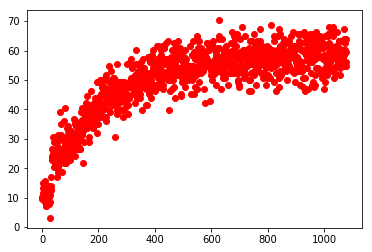

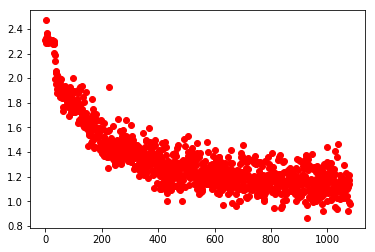

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

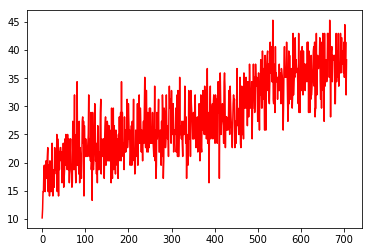

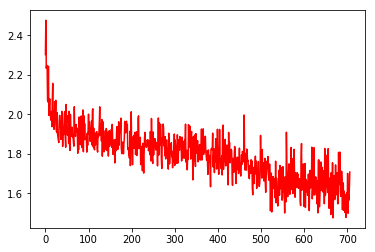

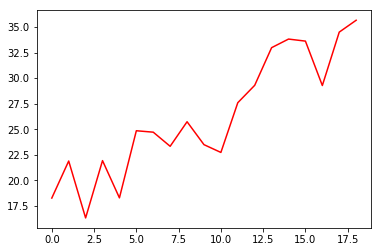

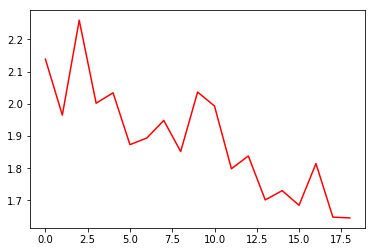

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()